# Testing software

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import stan_utility
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns
from scipy.integrate import quad

## Sources

In [2]:
from python.source.simple_source import PointSource, DiffuseSource, TestSourceList
from python.source.flux_model import PowerLawSpectrum, IsotropicDiffuseBG
from python.source.parameter import Parameter
Parameter.clear_registry()
from python.source.atmospheric_flux import AtmosphericNuMuFlux
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [3]:
atmo_bg_flux = AtmosphericNuMuFlux(1E2 * u.GeV, 1E9 * u.GeV)
atmo_bg_flux.total_flux_int

<Quantity 0.30188677 1 / (m2 s)>

In [4]:
source = PointSource.make_powerlaw_source(
    "test", 1*u.rad, 2*u.rad, 1E55*u.erg/u.s, 2.2, 1, 1E2*u.GeV, 1E9*u.GeV)
print(source.luminosity)
print(source.parameters["norm"])

1.0000000000000001e+55 erg / s
Parameter test_norm = 6.242457975475833e-08 1 / (GeV m2 s)


In [5]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'

ps_norm = Parameter(0.5*1E-11 /u.GeV/u.m**2/u.s, "ps_norm", fixed=True, par_range=(0, np.inf))
index = Parameter(2.1, "index", fixed=False, par_range=(1.1, 4))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, par_range=(0, np.inf))

source_list = TestSourceList(source_file, spectral_shape=PowerLawSpectrum(ps_norm, 1E3*u.GeV, index, lower_energy=1E2*u.GeV, upper_energy=1E9*u.GeV))

# Select sources below zth = 1
zth = 1.0
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1

diffuse_flux_model = IsotropicDiffuseBG(PowerLawSpectrum(diffuse_norm, 1E5*u.GeV, index, lower_energy=1E2*u.GeV, upper_energy=1E9*u.GeV))

diffuse_bg = DiffuseSource('diffuse_bg', zth, flux_model=diffuse_flux_model)
source_list.add(diffuse_bg)

atmo_bg = DiffuseSource('atmo_bg', 0, flux_model=atmo_bg_flux)
source_list.add(atmo_bg)

In [6]:
source_list[-1].flux_model.total_flux_int

<Quantity 0.30188677 1 / (m2 s)>

In [7]:
source_list[-2].flux_model.total_flux_int

<Quantity 2.61197971e-06 1 / (m2 s)>

In [8]:
source_ints = [source.flux_model.total_flux_int for source in source_list]

In [9]:
f = sum(source_ints[:-2]) / sum(source_ints[:-1])
print(f)

0.4476983973700852


In [10]:
source_list.sources[0].parameters["index"].value = 3
print(source_list.sources[1].parameters["norm"].value)
print(source_list.sources[0].luminosity)

5e-12 1 / (GeV m2 s)
1.6458997692407433e+46 erg / s


## Precomputation

In [15]:
from python.precomputation import ExposureIntegral
from python.detector_model import NorthernTracksDetectorModel

In [16]:
time = 8 * u.year # years -> not used rn
Edet_min = 1.0e5 * u.GeV # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksDetectorModel, 
                                     time, Edet_min)

exposure_integral()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x1227f4cd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x1227fc110> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x121fdc0d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x122805850> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x10f441210> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11222a850> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x121e38e90> already on stack
INFO:python.backend.code_gener

In [17]:
# Something wrong??
exposure_integral.calculate_rate(source_list[-1]).to(1 / u.yr)

<Quantity 18757.87112858 1 / yr>

In [45]:
source_list.sources[0].flux_model.spectral_shape.integral(1e2 * u.GeV, 5e2 * u.GeV)
#source_list.sources[0].flux_model.spectral_shape.energy_bounds

<Quantity 1.65333333e-06 1 / (m2 s)>

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


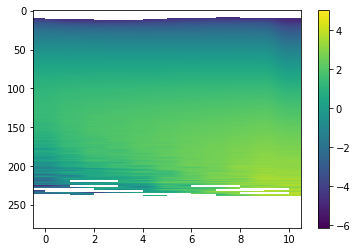

In [18]:
fig, ax = plt.subplots()
plt.imshow(np.log10(exposure_integral._effective_area._eff_area), aspect='auto')
plt.colorbar()

In [19]:
(exposure_integral.integral_grid[-1][20] / diffuse_bg.redshift_factor(1)).to(1/u.yr)

UnitConversionError: 'm2 s / GeV' and '1 / yr' (frequency) are not convertible

In [ ]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.par_grids["index"], _)

## Generate Stan code for simulation


In [19]:
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext, FunctionCall, ModelContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

In [20]:
with StanGenerator() as cg:
    ntd = NorthernTracksDetectorModel()
    effective_area = ntd.effective_area
    energy_resolution = ntd.energy_resolution

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11b7c2f10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11b7667d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11b748510> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11b73c690> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11b766c10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11b75c750> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11b777290> already on stack
INFO:python.backend.code_gener

In [ ]:
true_energy = 10**np.linspace(3, 8) * u.GeV
threshold_energy = 1e5 * u. GeV
energy_resolution.prob_Edet_above_threshold(true_energy, threshold_energy)

### Test sampling functions

In [ ]:
Ns = 100000
with StanFileGenerator("stan_files/test.stan") as cg:
    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("interpolation.stan")
    
    
    spectrum_rng = source.flux_model.spectral_shape.make_stan_sampling_func("spectrum_rng")
    diffuse_flux_rng = diffuse_flux_model.make_stan_sampling_func("diffuse_bg_rng")
    atmu_nu_flux = atmo_bg_flux.make_stan_function(theta_points=100)
    
    with ParametersContext():
        energy = ParameterDef("energy", "real", 1E2, 1E9)
        coszen = ParameterDef("coszen", "real", -1, 1) 
        
    with TransformedParametersContext():
        omega = ForwardVariableDef("omega", "vector[3]")
        zen = ForwardVariableDef("zen", "real")
        sinzen = ForwardVariableDef("sinzen", "real")
        
        zen << FunctionCall([coszen], "acos")
        sinzen  << FunctionCall([zen], "sin")
        
        omega[1] << sinzen
        omega[2] << 0
        omega[3] << coszen
  
    with ModelContext():
        
        logflux = FunctionCall([atmu_nu_flux(energy, omega)], "log")
        StringExpression(["target += ", logflux])
       
    with GeneratedQuantitiesContext():
        pl_samples = ForwardVariableDef("pl_samples", "real")
        diffuse_events = ForwardVariableDef("diffuse_events", "vector[3]") 

        #with ForLoopContext(1, Ns, "i") as i:
        pl_samples << spectrum_rng(2, 1E2, 1E9)
        diffuse_events << diffuse_flux_rng(2, 1E2, 1E9)

In [ ]:
model = cg.generate_single_file()
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="sim")
simulation = sm.sampling(data={}, iter=1000, chains=1, 
                         algorithm="NUTS")

#### Diffuse events

In [ ]:
events = simulation.extract(["diffuse_events"])["diffuse_events"]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(np.log10(events[:, 0]), kde=False, ax = axs[0])
axs[0].set_yscale("log")
axs[0].set_xlabel("log10(Energy / GeV)")
axs[1].set_xlabel("sin(dec)")
sns.distplot(np.sin(events[:, 1]), kde=False, ax = axs[1])
plt.tight_layout()

#### Atmo events

In [ ]:
atmo_events = simulation.extract(["energy", "coszen"])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.distplot(np.log10(atmo_events["energy"]), kde=False, ax = axs[0])
axs[0].set_yscale("log")
axs[0].set_xlabel("log10(Energy / GeV)")
axs[1].set_xlabel("cos(zen)")
sns.distplot(atmo_events["coszen"], kde=False, ax = axs[1])
plt.tight_layout()
plt.semilogy()

#### Compare sampled energies to true spectrum integrated over dOmega

In [ ]:
np.sin(-np.pi/2)

In [ ]:
energies = np.logspace(2, 9, 50)
coszens = np.linspace(-1, 1, 100)

dec = -np.arcsin(coszens)
for e in energies[:10]:
    plt.plot(coszens, atmo_bg_flux(e * u.GeV, dec * u.rad, 0*u.rad))
plt.semilogy()
plt.figure()

plt.plot(energies, atmo_bg_flux.total_flux(energies * u.GeV))
plt.loglog()



In [ ]:
energies = np.logspace(2, 9, 100) << u.GeV
log_bins = np.linspace(2, 4, 50) 

integrate_per_log = atmo_bg_flux.integral(
    10**log_bins[:-1] * u.GeV, 10**log_bins[1:] * u.GeV,
    (-np.pi/2) * u.rad, (np.pi/2) * u.rad,
    0 * u.rad, 2*np.pi * u.rad) / np.diff(log_bins) / atmo_bg_flux.total_flux_int

fluxes = atmo_bg_flux.total_flux(energies) / atmo_bg_flux.total_flux_int

sns.distplot(np.log10(atmo_events["energy"]), kde=False, norm_hist=True, label="Energy Samples")
plt.step(log_bins, np.append(integrate_per_log, integrate_per_log[-1]), where="post", label="True Spectrum")
plt.semilogy()
plt.legend()
plt.xlabel("log10(Energy / GeV)")
plt.ylabel("Prob. per log bin")

In [ ]:
with StanFileGenerator("stan_files/detector_model_test") as cg:
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF)
    cg.generate_files()

In [ ]:
with StanFileGenerator("stan_files/sim_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        _ = Include("energy_spectrum.stan")
            
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Emin = ForwardVariableDef("Emin", "real")
        
        # Flux
        Q = ForwardVariableDef("Q", "real")
        F0 = ForwardVariableDef("F0", "real")
        
        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        Ngrid_str = ["[", Ngrid, "]"]
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+1]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([Fs," += ", F[k]])
        
        StringExpression("F[Ns+1]") << F0
        
        FT << Fs + FT
        f << StringExpression([Fs, "/", FT])
        
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", alpha, 
                                 ", ", alpha_grid, ", ", integral_grid, ", ", Ns, ")"])
        Nex << StringExpression(["get_Nex(", F, ", ", eps, ")"])
        w_exposure << StringExpression(["get_exposure_weights(", F, ", ", 
                                              eps, ")"])
        N << StringExpression(["poisson_rng(", Nex, ")"])
        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])
        
    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")
        
        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")
        
        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")
        
        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:
            
            lam[i] << StringExpression(["categorical_rng(", w_exposure,")"])
            
            accept << 0
            ntrials << 0
            
            with WhileLoopContext([accept != 1]):
                with IfBlockContext([StringExpression([lam[i], "<", Ns + 1])]):
                    omega << varpi[lam[i]]
                with ElseIfBlockContext([lam[i] == Ns + 1]):
                    omega << FunctionCall([1], "sphere_rng")
                cosz[i] << FunctionCall([FunctionCall([omega], "omega_to_zenith")], "cos")

                # Sample energy

                Esrc[i] << FunctionCall([alpha, Emin * (1 + redshift[lam[i]])], "spectrum_rng")
                E[i] << Esrc[i] / (1 + redshift[lam[i]])

                # Test against Aeff
                with IfBlockContext([StringExpression([cosz[i], ">= 0.1"])]):
                    Pdet[i] << 0
                with ElseBlockContext():
                    Pdet[i] << ntd_pdf.effective_area(E[i], omega) / aeff_max

                prob[1] << Pdet[i]
                prob[2] << 1 - Pdet[i]
                StringExpression([ntrials, " += ", 1])
                # StringExpression(["print(", Pdet[i], ")"])
                with IfBlockContext([StringExpression([ntrials, "< 10000"])]):
                    accept << FunctionCall([prob], "categorical_rng")
                with ElseBlockContext():
                    accept << 1
                    StringExpression(["print(\"problem component: \", ", lam[i], ");\n"])

                #accept << StringExpression(["categorical_rng(", prob, ")"])
            
            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            Edet[i] << ntd_rng.energy_resolution(E[i])


    sim = cg.generate_single_file()

In [ ]:
cg._base_filename

In [ ]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="sim")

## Simulation

In [ ]:
def to_unit_vector(dec, ra):
    theta = dec + np.pi/2
    x = np.sin(theta) * np.cos(ra)
    y = np.sin(theta) * np.sin(ra)
    z = np.cos(theta)
    return [x, y, z]

In [ ]:
redshift = [source_list.sources[i].redshift for i in range(source_list.N)]
lum_dist = [luminosity_distance(_) for _ in redshift]
varpi = np.asarray([to_unit_vector(*np.radians(source_list.sources[i].coord)) for i in range(source_list.N-1)])

In [ ]:
# Inputs 
sim_inputs = {}
sim_inputs['Ns'] = source_list.N-1

sim_inputs['z'] = redshift
sim_inputs['D'] = lum_dist[:-1]
sim_inputs['varpi'] = varpi_in

inputs['Ngrid'] = len(exposure_integral.par_grids[0])
inputs['alpha_grid'] = exposure_integral.par_grids[0]
inputs['integral_grid'] = exposure_integral.integral_grid

inputs['aeff_max'] = np.max(exposure_integral.effective_area._eff_area)

In [ ]:
#inputs['aeff_max'] = 1e4

In [ ]:
sim_inputs['alpha'] = 2.0
sim_inputs['Emin'] = 1e5 # GeV

total_flux = source_list.total_flux_int() # m^-2 s^-1

inputs['T'] = 1 * 3.154E7 # s
inputs['F0'] = ((1 - f) * total_flux) # m^-2 yr^-1
inputs['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*3.086e22)**2) 
                                          for d in inputs['D']])) )  # yr^-1

In [ ]:
# Simulate
simulation = sm.sampling(data=sim_inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u

class Direction():
    """
    Input the unit vector vMF samples and
    store x, y, and z and galactic coordinates
    of direction in Mpc.
    """

    def __init__(self, unit_vector_3d):
        """
        Input the unit vector samples and
        store x, y, and z and galactic coordinates
        of direction in Mpc.

        :param unit_vector_3d: a 3-dimensional unit vector.
        """

        self.unit_vector = unit_vector_3d
        transposed_uv = np.transpose(self.unit_vector)
        self.x = transposed_uv[0]
        self.y = transposed_uv[1]
        self.z = transposed_uv[2]
        self.d = SkyCoord(self.x, self.y, self.z,
                          unit = 'mpc',
                          representation_type = 'cartesian',
                          frame = 'icrs')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [ ]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet_sim = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad


true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi_in)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [ ]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = sim_inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

circles = []
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7))
collection = PatchCollection(circles, match_original=True)    
ax.add_collection(collection)   

circles = []
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm))
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)
ax.axhline(np.deg2rad(-5), color='k', linestyle=":")

In [ ]:
# Plot energies
Emin_cascades = sim_inputs['Emin']
bins = np.logspace(np.log(Emin_cascades/1000), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet_sim, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.axvline(sim_inputs["Emin"])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Generate Stan code for fit

In [ ]:
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [ ]:
with StanFileGenerator("stan_files/model_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("energy_spectrum.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Emin = ForwardVariableDef("Emin", "real")
        
         # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        Eg = ForwardVariableDef("E_grid", "vector[Ngrid]")
        Pg = ForwardArrayDef("Pdet_grid", "vector[Ngrid]", Ns_1p_str)
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
        # Debugging
        Q_scale = ForwardVariableDef("Q_scale", "real")
        F0_scale = ForwardVariableDef("F0_scale", "real")
        
        
    with TransformedDataContext() as tdc:
        
        zenith = ForwardVariableDef("zenith", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            zenith[i] << StringExpression(["pi() - acos(", omega_det[i][3], ")"])
        
        StringExpression(["print(", Ngrid, ")"])
            
    with ParametersContext() as pc:
        
        Q = ParameterDef("Q", "real", 0.0, 1e60)
        F0 = ParameterDef("F0", "real", 0.0, 500)
        
        alpha = ParameterDef("alpha", "real", 1.5, 3.5)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Emin, 1e8)
        
    with TransformedParametersContext() as tpc:
        
        Fs = ParameterDef("Fs", "real", 0.0)
        
        F = ForwardVariableDef("F", "vector[Ns]")
        allF = ForwardVariableDef("allF", "vector[Ns+1]")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        f = ParameterDef("f", "real", 0, 1)
        FT = ParameterDef("FT", "real", 0)
        
        lp = ForwardArrayDef("lp", "vector[Ns+1]", N_str)
        logF = ForwardVariableDef("logF", "vector[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        E = ForwardVariableDef("E", "vector[N]")       
        
        Fs << 0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                      D[k], " * ", 3.086e22, ", 2))"])
            allF[k] << F[k]
            StringExpression([Fs," += ", F[k]])
        StringExpression("allF[Ns+1]") << F0
        FT << F0 + Fs
        f << StringExpression([Fs, " / ", FT]) 
        
        logF << StringExpression(["log(", allF, ")"])
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << logF 
            with ForLoopContext(1, "Ns+1", "k") as k:
                StringExpression([lp[i][k], " += pareto_lpdf(", Esrc[i], 
                                  " | ", Emin, " , ", alpha-1, ")"])
                E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"]) 
                
                StringExpression(["if (", k ," < Ns+1) {\n", 
                                  lp[i][k], " += ", 
                                  ntd.angular_resolution(E[i], 
                                                         varpi[k], omega_det[i]),
                                  ";\n}\n", "else if (", k, " == Ns+1) {\n", 
                                  lp[i][k], " += ", np.log(1/(4*np.pi)), 
                                  ";\n}"])
                
                StringExpression([lp[i][k], " += ", 
                                  ntd.energy_resolution(E[i], Edet[i])])
                StringExpression([lp[i][k], " += log(interpolate(", 
                                  Eg, ", ", Pg[k], ", ", E[i], "))"])
                       
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", 
                                 alpha, ", ", alpha_grid, ", ", 
                                 integral_grid, ", ", Ns, ")"])  
        Nex << StringExpression(["get_Nex(", allF, ", ", eps, ")"])
    
    with ModelContext() as mc:
        
        with ForLoopContext(1, N, "i") as i:
            StringExpression(["target += log_sum_exp(", lp[i], ")"])
        StringExpression(["target += -", Nex])
        
        StringExpression([Q, " ~ normal(0, ", Q_scale, ")"])
        StringExpression([F0, " ~ normal(0, ", F0_scale, ")"])
        StringExpression([alpha, " ~ normal(2.0, 2.0)"])
        
    model = cg.generate_single_file()

In [ ]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="model")

In [ ]:
inputs = {}
inputs["N"] = len(Edet_sim)
inputs["omega_det"] = event.unit_vector
inputs["Edet"] = Edet_sim
inputs["Ns"] = source_list.N - 1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi_in

inputs["Emin"] = 1e5 # GeV

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid
inputs["E_grid"] = E_grid
inputs["Pdet_grid"] = Pdet_grid
inputs["Q_scale"] = sim_inputs["Q"]
inputs["F0_scale"] = sim_inputs["F0"]
inputs["T"] = 1

In [ ]:
# fit
fit = sm.sampling(data=inputs, iter=500, chains=4)

In [ ]:
# View chains
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r"Nex"]);
fig.set_size_inches(20, 16)
fig.tight_layout()

In [ ]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
truths = [sim_inputs['F0'], sim_inputs['Q'], total_flux, 0.5, sim_inputs['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, truths = truths);